In [1]:
import shutil, os

In [2]:
from glob import glob

In [3]:
import numpy as np, pandas as pd

C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import GroupKFold

In [6]:
from tqdm.notebook import tqdm

In [7]:
import seaborn as sns

In [8]:
from ultralytics import YOLO

In [9]:
from os import listdir

In [10]:
from os.path import isfile, join

In [11]:
import yaml

In [12]:
fold = 4

In [13]:
train_df = pd.read_csv(f'Dataset/train.csv')

In [14]:
train_df['image_path'] = f'Dataset/train/'+train_df.image_id+('.png')

In [15]:
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580,Dataset/train/50a418190bc3fb1ef1633bf9678929b3...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159,Dataset/train/21a10246a5ec7af151081d0cd6d65dc9...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336,Dataset/train/9a5094b2563a1ef3ff50dc5c7ff71345...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880,Dataset/train/051132a778e61a86eb147c7c6f564dfe...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072,Dataset/train/063319de25ce7edb9b1c6b8881290140...


In [16]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [17]:
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

In [18]:
train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

In [19]:
train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

In [20]:
train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

In [21]:
train_df['area'] = train_df['w']*train_df['h']

In [22]:
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,Dataset/train/9a5094b2563a1ef3ff50dc5c7ff71345...,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,Dataset/train/051132a778e61a86eb147c7c6f564dfe...,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,Dataset/train/1c32170b4af4ce1a3030eb8167753b06...,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,Dataset/train/0c7a38f293d5f5e4846aa4ca6db4daf1...,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,Dataset/train/47ed17dcb2cbeec15182ed335a8b5a9e...,0.239875,0.721145,0.045950,0.039368,0.001809


In [23]:
features = ['x_min', 'y_min', 'x_max', 'y_max', 'x_mid', 'y_mid', 'w', 'h', 'area']

In [24]:
X = train_df[features]

In [25]:
y = train_df['class_id']

In [26]:
X.shape, y.shape

((36096, 9), (36096,))

In [27]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [28]:
gkf  = GroupKFold(n_splits = 5)

In [29]:
train_df['fold'] = -1

In [30]:
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold

In [31]:
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,image_path,x_mid,y_mid,w,h,area,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,Dataset/train/9a5094b2563a1ef3ff50dc5c7ff71345...,0.563462,0.686216,0.462500,0.195205,0.090283,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,Dataset/train/051132a778e61a86eb147c7c6f564dfe...,0.623915,0.305903,0.150608,0.095833,0.014433,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,Dataset/train/1c32170b4af4ce1a3030eb8167753b06...,0.309843,0.128581,0.125984,0.024740,0.003117,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,Dataset/train/0c7a38f293d5f5e4846aa4ca6db4daf1...,0.773523,0.472407,0.368053,0.753033,0.277156,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,Dataset/train/47ed17dcb2cbeec15182ed335a8b5a9e...,0.239875,0.721145,0.045950,0.039368,0.001809,4


In [32]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())

In [33]:
os.makedirs('YoloDataset/labels/train', exist_ok = True)
os.makedirs('YoloDataset/labels/val', exist_ok = True)
os.makedirs('YoloDataset/images/train', exist_ok = True)
os.makedirs('YoloDataset/images/val', exist_ok = True)
label_dir = 'Dataset/labels'
for file in tqdm(train_files):
    shutil.copy(file, 'YoloDataset/images/train/')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), 'YoloDataset/labels/train')
        
for file in tqdm(val_files):
    shutil.copy(file, 'YoloDataset/images/val/')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), 'YoloDataset/labels/val')

  0%|          | 0/3515 [00:00<?, ?it/s]

  0%|          | 0/879 [00:00<?, ?it/s]

In [34]:
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [35]:
cwd = 'YoloDataset/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('YoloDataset/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('YoloDataset/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: YoloDataset/train.txt
val: YoloDataset/val.txt



In [36]:
can_train = False

In [37]:
if can_train:
    model = YOLO('yolov8n.yaml')
    results = model.train(data='vinbigdata.yaml', epochs=3, imgsz=512)
else:
    model = YOLO('Chest-XRay-VinBigData.pt')

In [38]:
%matplotlib inline

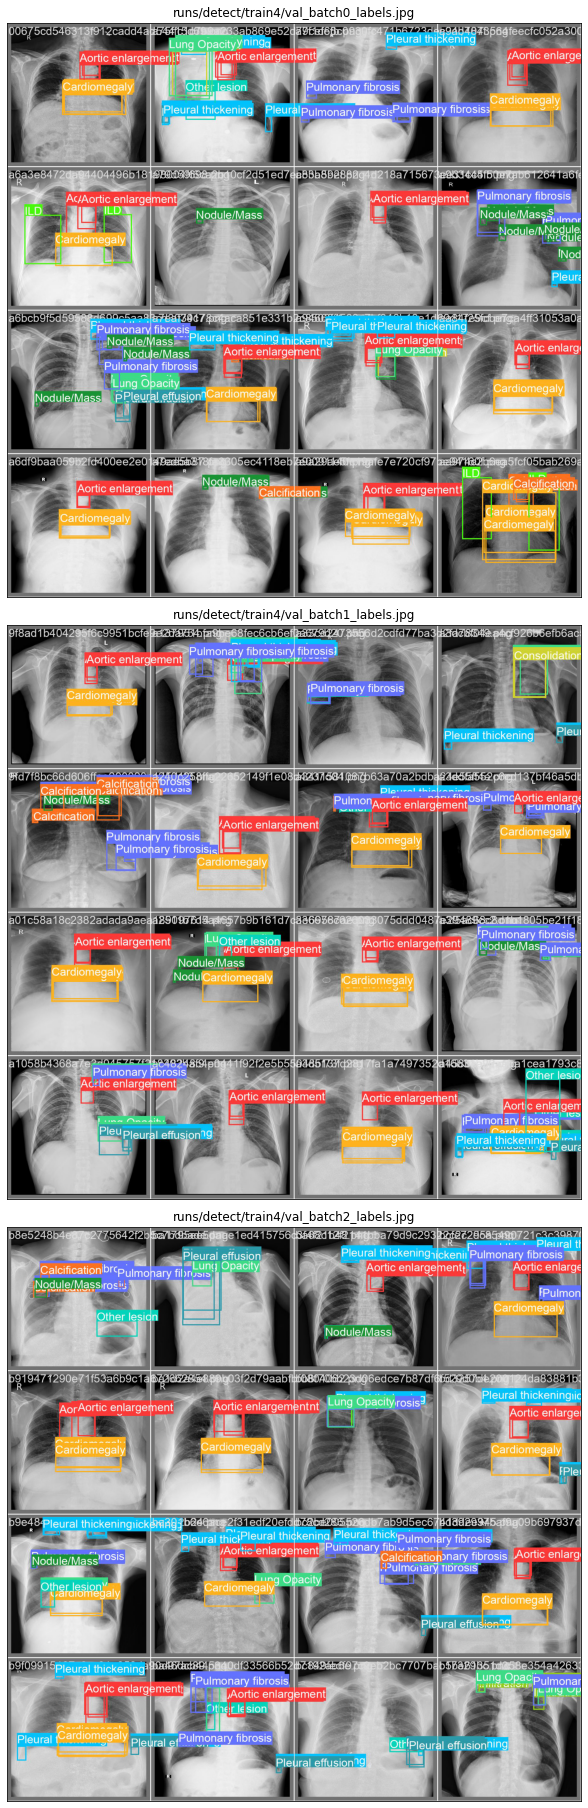

In [39]:
fig, ax = plt.subplots(3, 1, figsize = (5*5,5*5), constrained_layout = True)
for row in range(3):
    ax[row].imshow(plt.imread(f'runs/detect/train4/val_batch{row}_labels.jpg'))
    ax[row].set_xticks([])
    ax[row].set_yticks([])
    ax[row].set_title(f'runs/detect/train4/val_batch{row}_labels.jpg', fontsize = 12)
    
   

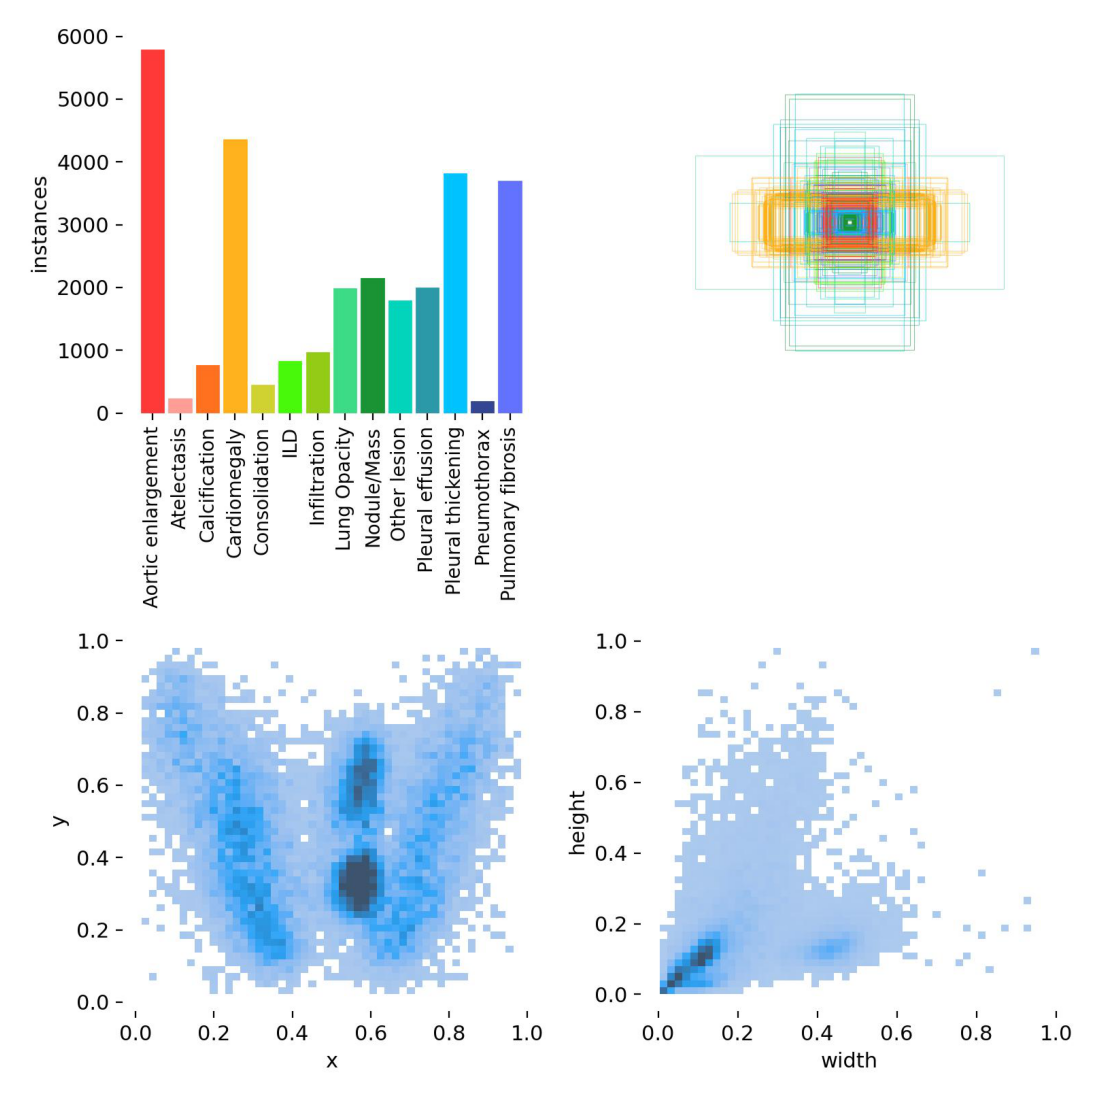

In [40]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/detect/train4/labels.jpg'));

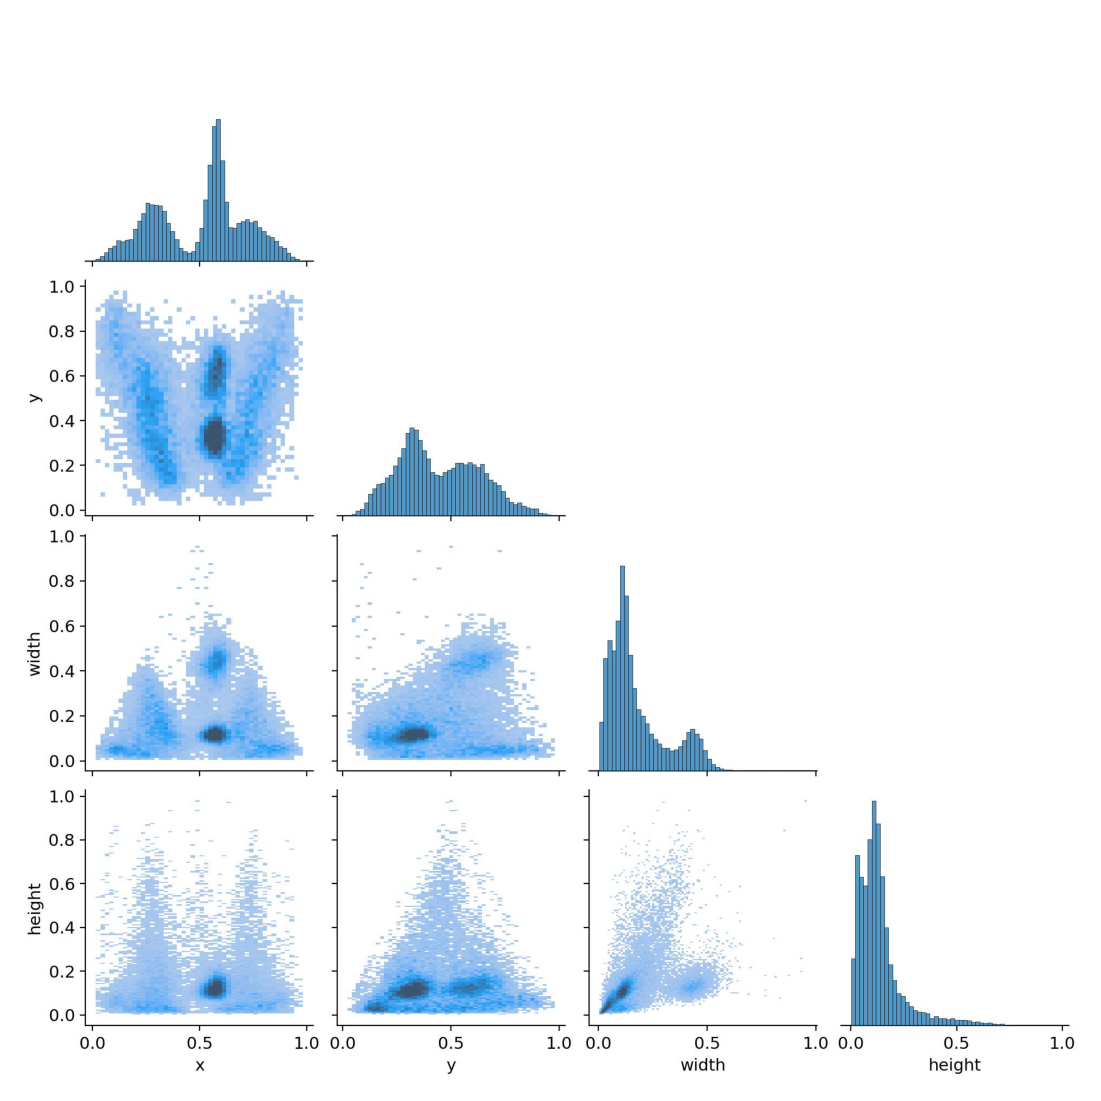

In [41]:
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(plt.imread('runs/detect/train4/labels_correlogram.jpg'));

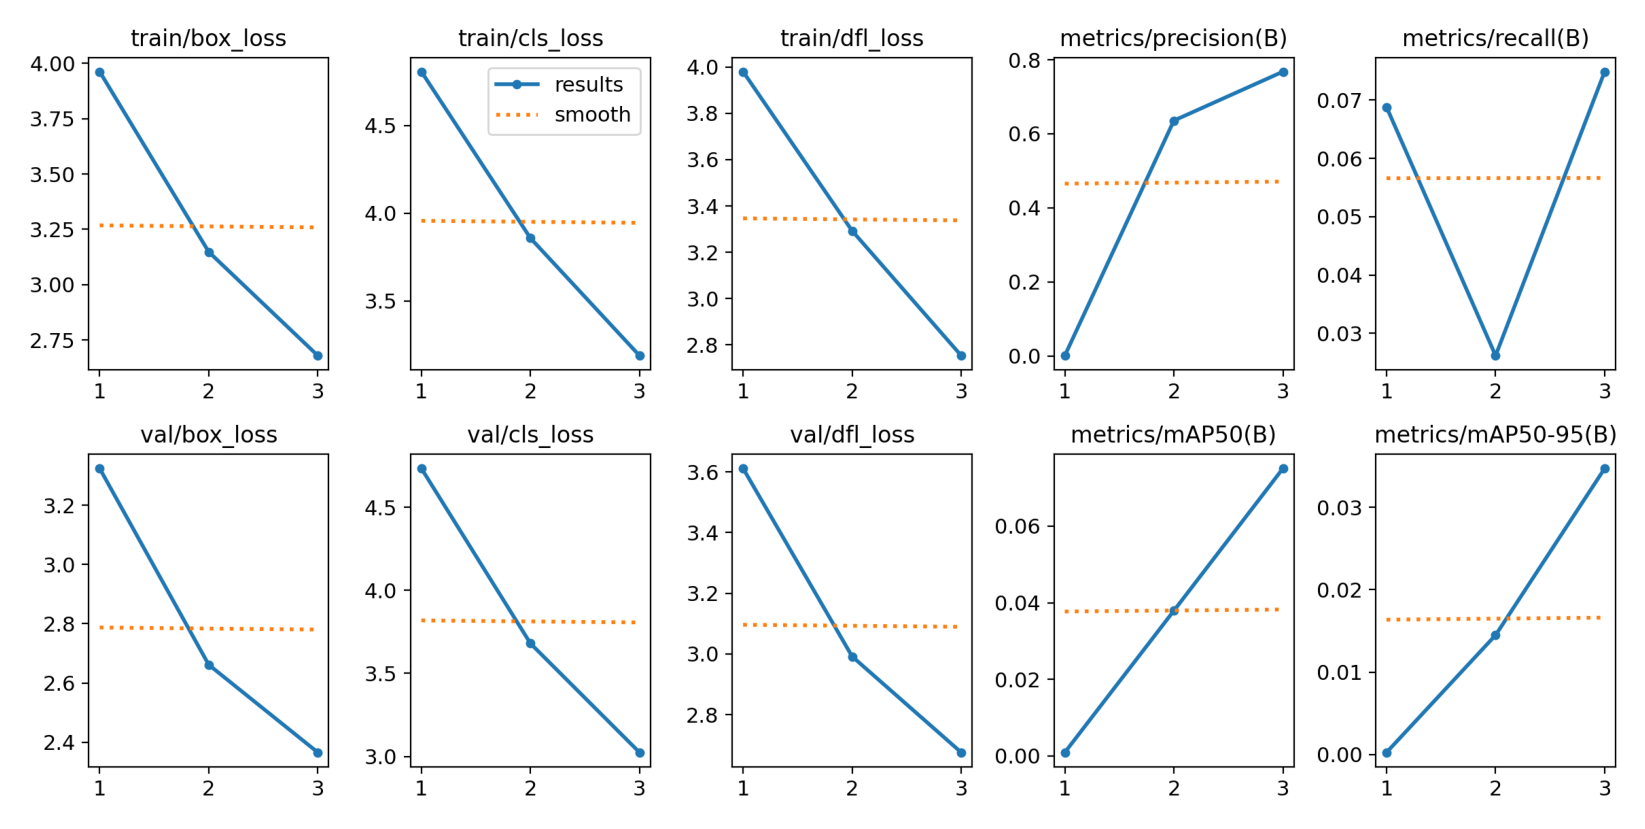

In [42]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/detect/train4/results.png'));